# Groningen Seismicity model
This notebook allows running the seismicity model developped at GMG for gas extraction from the Groningen gas field following Smith et al., 2022, Heimisson et al., 2022, and Meyer et al.,2022.

The most complete description of the model can be found in:

Smith, J. D., Heimisson, E. R., Bourne, S. J., & Avouac, J. P. (2022). Stress-based forecasting of induced seismicity with instantaneous earthquake failure functions: applications to the Groningen Gas Reservoir. Earth and Planetary Science Letters, 594, 117697.

---and---

Heimisson, E. R., Smith, J. D., Avouac, J. P., & Bourne, S. J. (2022). Coulomb threshold rate-and-state model for fault reactivation: application to induced seismicity at Groningen. Geophysical Journal International, 228(3), 2061-2072.


A full description of the needed libraries and tested practice on installation and running can be found in the file: Groningen_GMG_Seismicity_model_libraries.txt

A description of the integration of this module with the rest of the modelling workflow can be found in the file:
../README_GroningenModels_GMG.txt

## 1. Libraries and data set-up

### 1.1. Import Libraries

In [1]:
import pymc3 as pm
import numpy as np
from numpy.lib.stride_tricks import as_strided # to average arrays
import matplotlib.pylab as plt
import seaborn as sns
from math import *
import pandas as pd 
from matplotlib.patches import Circle, Wedge, Polygon
import scipy
import theano.tensor as tt
#the fancy axes
import matplotlib.gridspec as gridspec
# Gaussian Smoothing
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

### 1.2. Import functions

In [2]:
from Functions.Plotting_functions import cornerplot, rateplot
from Functions.Failure_functions import *
from Functions.Forecasting_functions import *

## 2. MCMC inference

### 2.1. Define the method to be used, and inference parameters

In [3]:
# Choose the failure function to be used
## TRS == Treshold Rate and State --> Heimisson et al., 2022
## RS == Classic Rate and State --> Dieterich., 1994
## ET == Extreme Threshold --> Bourne et al., 2017
## GF == Gaussian Failure --> Smith et al., 2022
Failure_function = 'TRS'
LogLikelihood = 'Gaussian'

if Failure_function =='TRS':
    method = ThresholdRateAndState_logSampled()
    labels = ['$r$ (evts/year)','$A \sigma$ (MPa)','$\Delta S_c$ (MPa)','$t_a$ (years)']
    LLK = LogLikelihood # log likelihood
    
elif Failure_function =='RS':
    method = ClassicRateAndState_logSampled() 
    labels = ['$r$ (evts/year)','$A \sigma$ (MPa)','$t_a$ (years)']
    LLK = LogLikelihood # log likelihood

elif Failure_function =='ET':
    method = ExtremeThreshold() 
    labels = ['$\beta_0$','$\beta_1$','$\beta_2$']
    LLK = LogLikelihood # log likelihood

elif Failure_function =='GF':
    method = GaussianFailure()
    labels = ['$\beta_0$','$\beta_1$','$\beta_2$']
    LLK = LogLikelihood # log likelihood
    
# Define parameters for the inversions
Num_samples = 5000 # samples for the MCMC inversion
Warmup_percentage = 20 # percentage burn-in samples
Num_chains = 10  #number of chains for the inversion
Training = [1992,2016] # Training period
Validation = [2016,2022] # Validation period

### 2.2. Prepare the data for the MCMC

In [4]:
# Load the Coulomb Stress data
dC_raw = np.load('../Simulation_results/Mechanical_model/max_coulomb_stresses_resampled_mp.npy',allow_pickle=True)
# Smooth it to 3km 
kernel = Gaussian2DKernel(6)
dC = np.array([convolve(dC_raw[:,:,ii],kernel,nan_treatment='fill') for ii in range(dC_raw.shape[-1])]).transpose((1, 2, 0))
#Load time
tt=np.load('../Simulation_results/Reservoir_model/time_decimal_resampled_mp.npy',allow_pickle=True)

# Average yearly
dC_y ={} # Disctionnary to store the yearly data
dC_y['Coulomb'] = np.nanmean(as_strided(dC, shape=(dC.shape[0], dC.shape[1], int(dC.shape[-1]/12), 12),strides=(dC.strides[0], dC.strides[1], dC.strides[2]*12, dC.strides[2])),axis=3)
dC_y['Time']    = tt[0::12][:-1].round(0)

# Load the seismicity catalog
catalog_file = '../Inputs/Seismic_catalog/KNMI_CAT_1991-12to2023-01_InsideReservoir.csv'

# Define the completion magnitude to use
Mc =1.2

### 2.3. Run MCMC

In [5]:
# Run the MCMC inversion
# Create the forecasting object
SF = SeismicityForecasting(method,catalog_file,dC_y,num_samples=Num_samples,warmup_percentage=Warmup_percentage,num_chains=Num_chains,Mc=Mc)# load the forecasting model and give the parameters)
# Run the inference
SF.run(training=Training,validation=Validation,LLK=LLK)

========= Training - Running MCMC =========


Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [θ4]
>Metropolis: [θ3]
>Metropolis: [θ2]
>Metropolis: [θ1]


Sampling 10 chains for 1_000 tune and 4_000 draw iterations (10_000 + 40_000 draws total) took 426 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Saving trace data
========= Training - Determine R_Pred,Betas,logp =========
Forecast Parameters :
<MultiTrace: 10 chains, 4000 iterations, 8 variables>
chains
10
draws
4000
samples
1000
========= Validation - Determine R_Pred,Betas,logp =========
========= Full-time Evolution - Determine R_Pred =========
Forecast Parameters :
<MultiTrace: 10 chains, 4000 iterations, 8 variables>
chains
10
draws
4000
samples
1000


## 3. Plot the results

### 3.1 The corner plots for best parameters

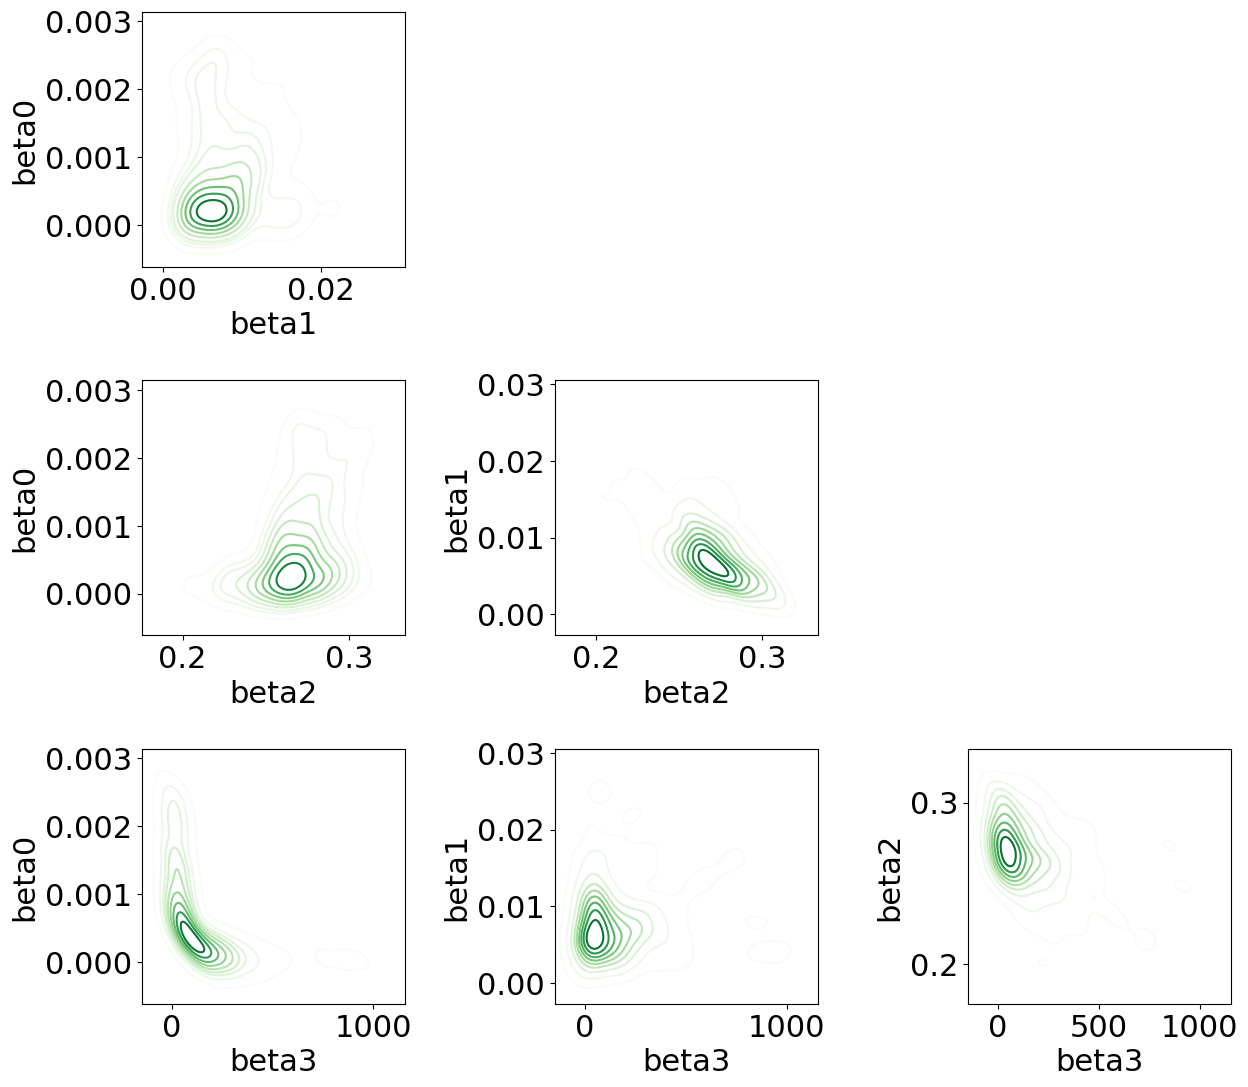

In [6]:
# Plot the data
File_cornerplot = None#f'Figures/cornerplot_method={method}.png'
cornerplot(SF,File_cornerplot)

### 3.2. The rate plots for temporal evolution

In [ ]:
File_rateplot = None#f'Figures/rateplot_method={method}.png'
rateplot(SF,File_rateplot)

In [ ]:
ds = {} #dictionnary containing the seismicity
ds['betas'] = SF.Training['betas']
ds['Rpred'] = SF.FullModel['Rpred']
ds['t_Rpred'] = SF.FullModel['Time']
# --  logn : normalization of logp
logn    = SF.Training['logp']-np.nanmin(SF.Training['logp'])
logn    = logn/np.nanmax(logn)
logpn   = 1 - logn
idx     = np.argsort(logpn)[::-1] #argsort returns the indexes to sort the table
ds['logp'] = SF.Training['logp']
ds['logp_normalized'] = logpn
# Observed catalog
ds['Robs']   = SF.FullModel['Robs']
ds['t_Robs'] = np.repeat(SF.Catalogue['Dates'],2)[1:]

#Training and validation periods
ds['Training'] = SF.training_period
ds['Validation'] = SF.validation_period

# Priors
ds['Priors'] = [[a,b] for a,b in zip(SF.ForecastingModel.prior_min,SF.ForecastingModel.prior_max)]

# Save the Forecast as is.
np.save('../Simulation_results/Seismicity_Model/Seismicity_forecast_From_mp.npy',ds,allow_pickle=True)





# track the date where this was run
import datetime
def update_run_date(file_path, model_name):
  """Updates the run date for a specific model in a text file.

  Args:
    file_path: The path to the text file.
    model_name: The name of the model to update.
  """

  now = datetime.datetime.now()
  new_date = now.strftime("%Y-%m-%d %H:%M:%S")

  lines = []
  with open(file_path, 'r') as f:
    for line in f:
      if model_name in line:
        lines.append(f"{model_name}: {new_date}\n")
      else:
        lines.append(line)

  with open(file_path, 'w') as f:
    f.writelines(lines)

file_path = "../../model_run_dates.txt"
update_run_date(file_path, "Groningen Seismicity Model")